## Demo for solving a bidomain equations on a rectangular domain

### Importing required libraries

In [1]:
# Moving to a correct directory
%cd ..
from src.models.dynamics_models import *
from src.models.cell_models import *
from src.utils import *
import ufl

/home/drvinko/Desktop/Modeliranje-biofizike-srcanog-tkiva


### Defining a domain, cell model and the whole model and visualizing initial data

In [2]:
domain = rectangle(3, 3, 64, 64)
x = ufl.SpatialCoordinate(domain)

In [3]:
class CellModel(ReparametrizedFitzHughNagumo):
    # Applying extrenal current
    def applied_current(self):
        self.I_app.interpolate(
            lambda x: 10*np.exp(-((x[0] - 1.5) ** 2)*10 - (x[1] - 1.5) ** 2*10)
        )
        self.I_app_duration = 20
        return self.I_app

In [4]:
# Creating a class that inherits from the BidomainModel class
# (it can inherit from MonodomainModel class if we want to use monodomain model)
class Model(BidomainModel):
    # Defining initial transmembrane potential (it can be defined to vary in space)
    def initial_V_m(self):
        self.V_m_n.x.array[:] = -85

    # Defining intracellular and extracellular conductivities
    def conductivity(self):
        x_c, y_c = 1, 1
        fibres = (
            (x[1] - y_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2 + 1),
            -(x[0] - x_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2 + 1),
        )
        # Muscle fibres
        self.fibres = ufl.as_vector(fibres)
        # Healthy conductivities
        self.M_i = self.SIGMA_IT * ufl.Identity(2) + (
            self.SIGMA_IN - self.SIGMA_IT
        ) * ufl.outer(self.fibres, self.fibres)
        self.M_e = self.SIGMA_ET * ufl.Identity(2) + (
            self.SIGMA_EN - self.SIGMA_ET
        ) * ufl.outer(self.fibres, self.fibres)

In [5]:
# Instantiating the cell model and dynamics model
cell_model = CellModel(domain)
model = Model(domain, cell_model)

In [6]:
plot_function(cell_model.applied_current(), camera_direction="xy")

Widget(value='<iframe src="http://localhost:46179/index.html?ui=P_0x7efe42191910_0&reconnect=auto" class="pyvi…

### Solving equations with given parameters

In [7]:
model.solve(
    T=500,
    steps=500,
    save_to="animations/*demo*.mp4",
    signal_point=[2.0, 2.0, 0.0],
)

Solving problem: 100%|██████████| 500/500 [05:59<00:00,  1.39it/s]


### Plotting fiber orientations

In [8]:
x_c, y_c = 1, 1
plot_vector_field(
    domain,
    lambda x: (
        (x[1] - y_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2 + 1),
        -(x[0] - x_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2 + 1),
        0,
    ),
    0.03,
)

### Plotting a final plot of transmembrane potential

In [9]:
plot_function(model.V_m_n, "V_m", show_mesh=False)

Widget(value='<iframe src="http://localhost:46179/index.html?ui=P_0x7efdf00bfa90_2&reconnect=auto" class="pyvi…

### Plotting a transmembrane potential in a given signal point

Text(0, 0.5, 'signal')

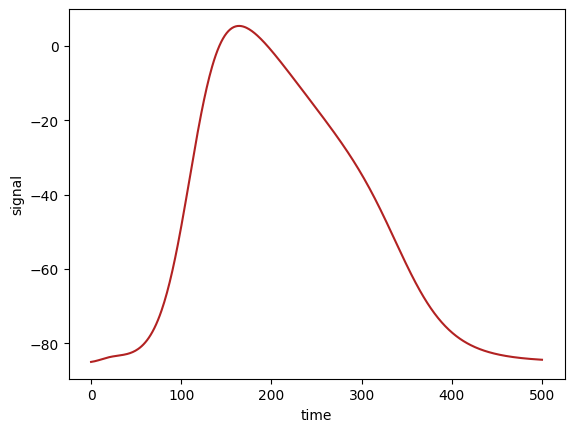

In [12]:
import matplotlib.pyplot as plt
plt.plot(model.time, model.signal, color='firebrick')
plt.xlabel('time')
plt.ylabel('signal')